# Workflows and Agents

Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents. 

It highlights both "agents" and "workflows":

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined "workflows". At Anthropic, we categorize all these variations as agentic systems.

It explains the primary difference between agents and workflows: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

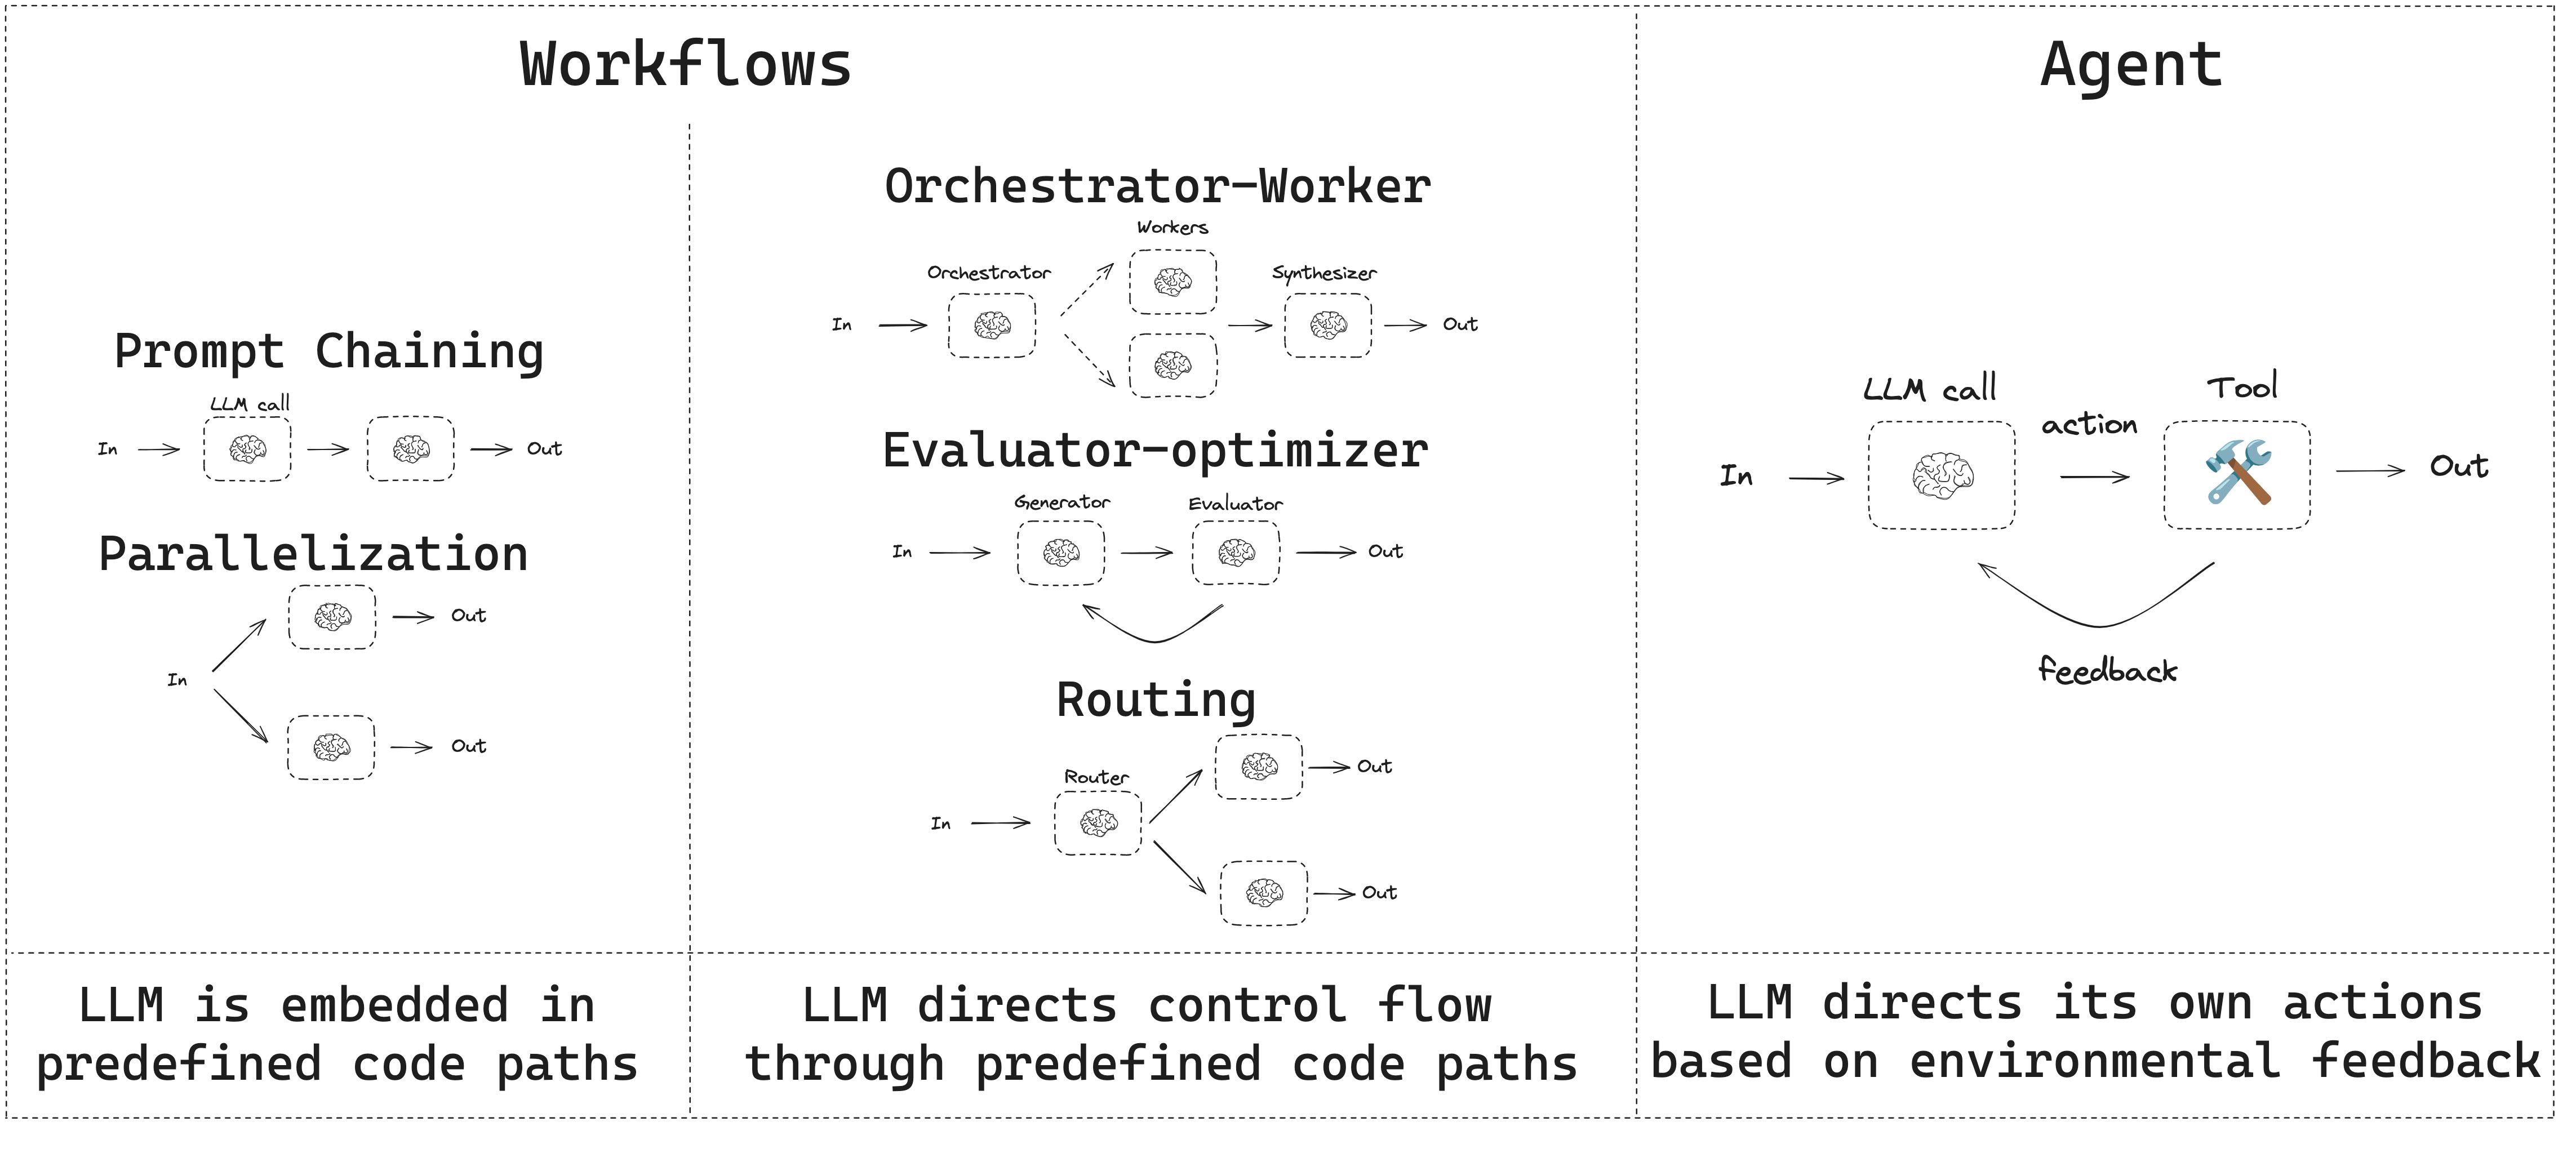

## Why use a framework like LangGraph?

With agents and workflows defined, the blog discusses whether to use agent frameworks.

For any framework, it is important to understand the costs (or overhead) of using it versus the benefits.

The blog points out that frameworks *can* add abstraction, often to promote speed or ease of use. 

But, this can come with costs, such as difficulty debugging or incorrect assumptions.

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts and responses, making them harder to debug.

LangGraph aims to minimize costs / overhead by providing low-level building blocks for building workflows / agents.

These building blocks can be flexibly used to build any workflow / agent architecture.

A central building block in LangGraph is the [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), which sits below any workflow or agent you implement.

This persistence layer enables several features are generally important for agents and workflows:

* Short-term and long-term [memory](https://langchain-ai.github.io/langgraph/concepts/memory/)
* [Interruption and resuming](https://langchain-ai.github.io/langgraph/concepts/breakpoints/) of workflows or agents
* [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) (e.g., to approve an agent's actions)
  
The blog makes an interesting point related to the importance of persistence:
 
> Agents can then *pause for human feedback at checkpoints* or when encountering blockers.

Beyond persistence, LangGraph provides a number of other benefits for building effective agents and workflows:

* Flexible streaming of agent or workflow state
* Easy onramp for deployment

We provide more resources on persistence, streaming, and deployment at the end of this document. 

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in the blog:

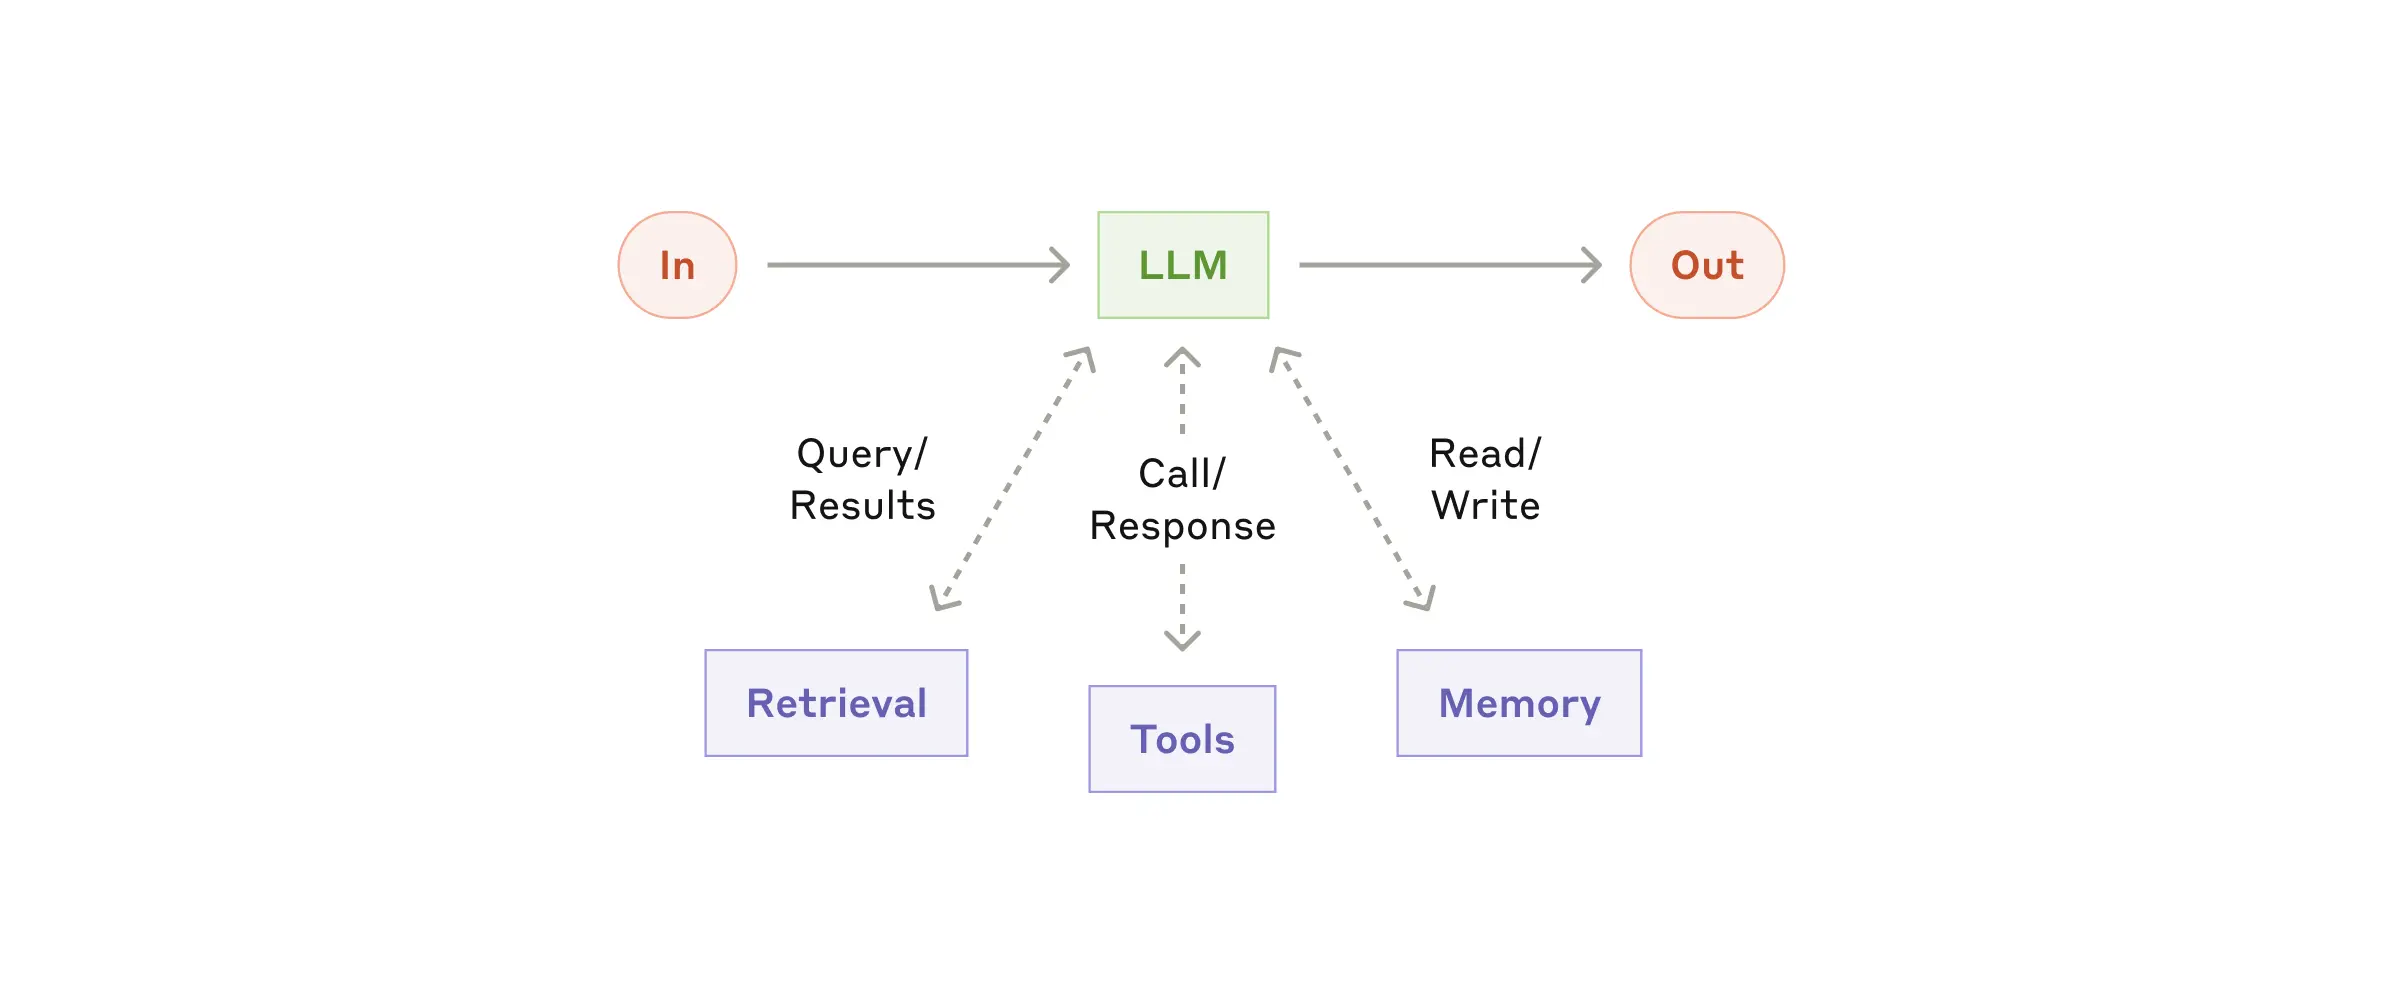

Select [any chat model](https://python.langchain.com/docs/integrations/chat/) that supports structured outputs or tool calling. 

Below, we show how to use LangGraph with OpenAI and Anthropic. 

In [1]:
%pip install langchain_core langchain-openai langchain-anthropic langgraph

In [2]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [3]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [4]:
from pydantic import BaseModel, Field


# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score relation to high cholesterol
Understanding the link between Calcium CT scores and cholesterol levels can help in assessing cardiovascular risks.


In [5]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_IqdREcwrgwEWvrRJSdFa13Jx',
  'type': 'tool_call'}]

## Prompt chaining

In prompt chaining, each LLM call processes the output of the previous one. As noted in the [blog](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

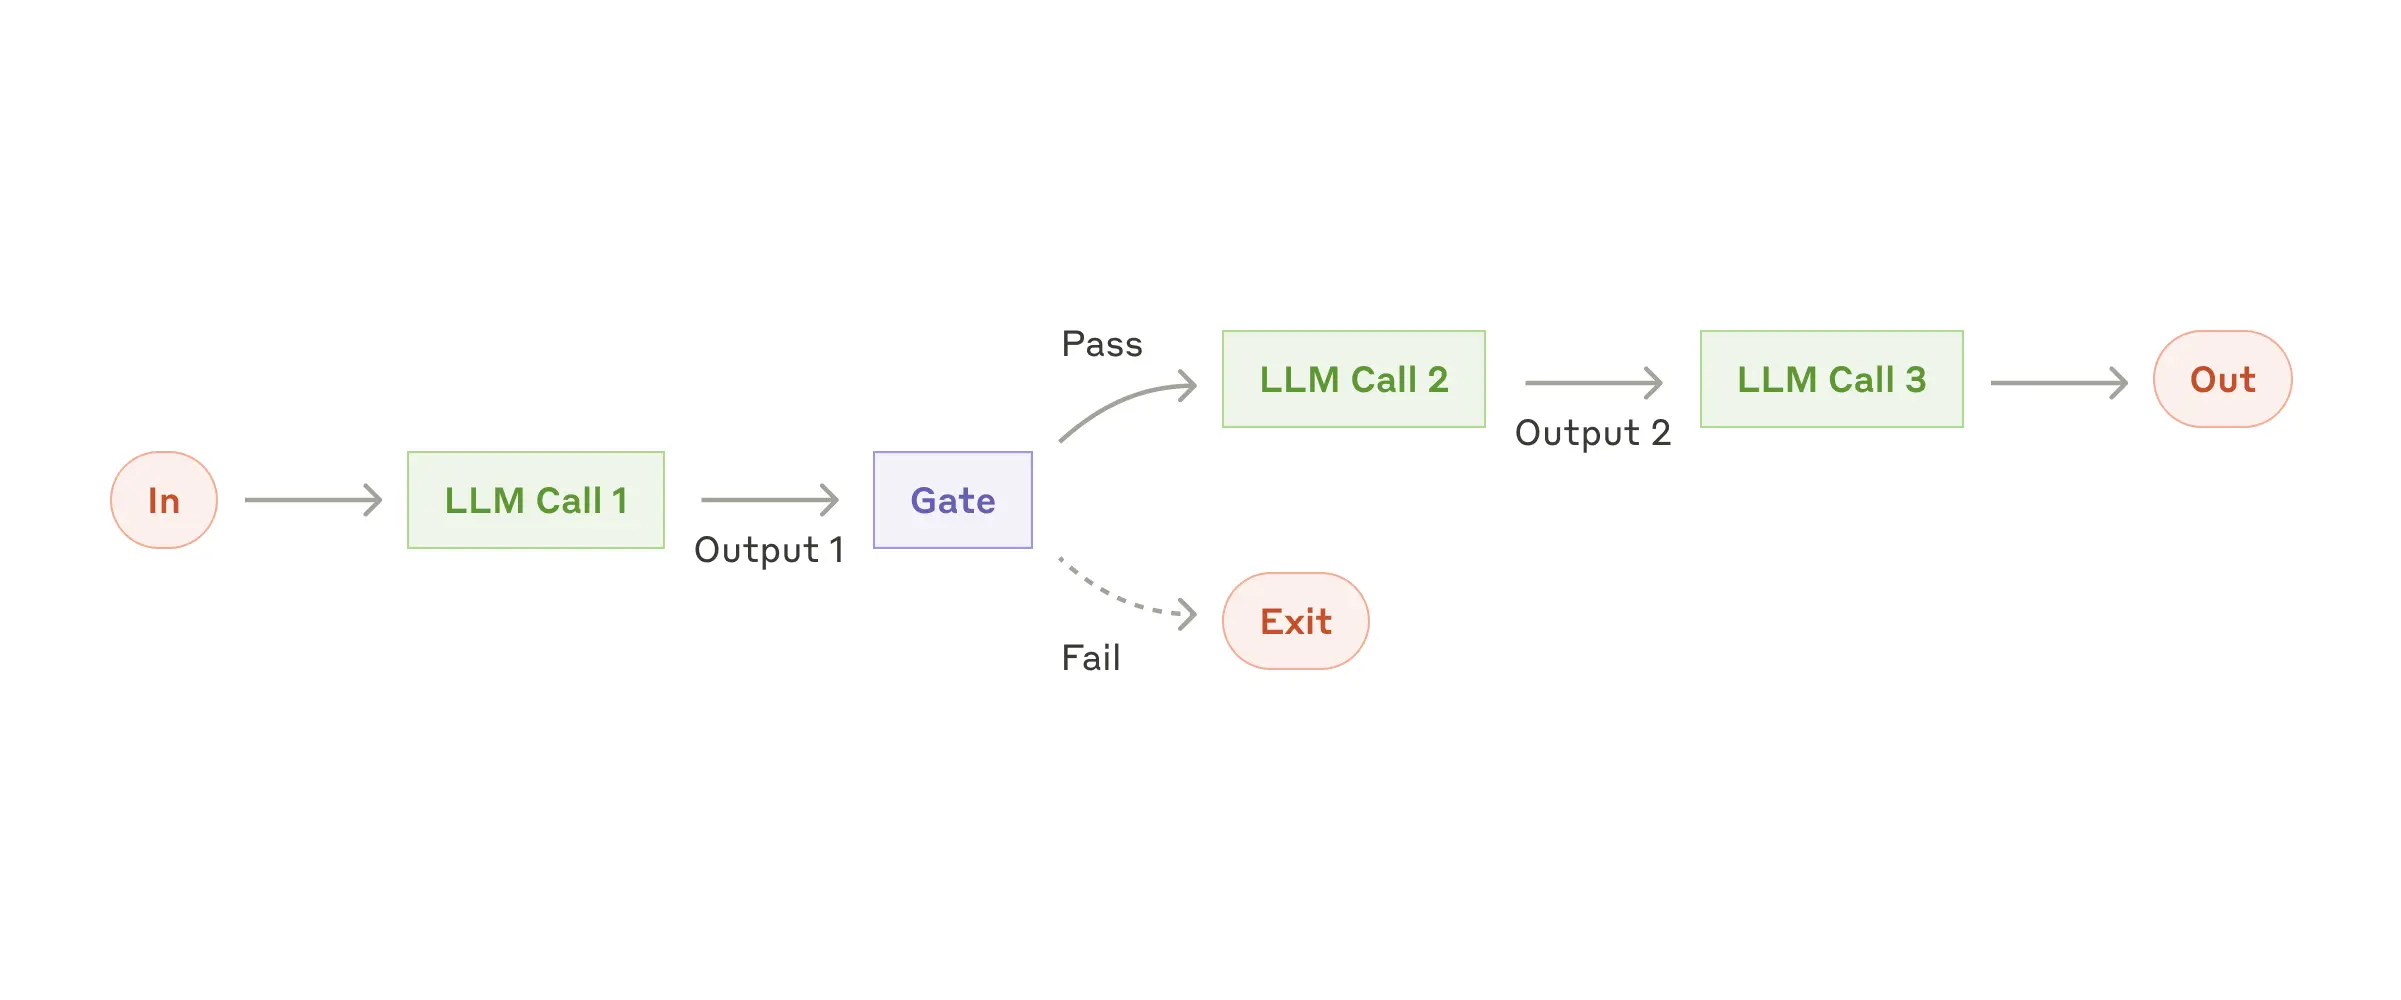

#### Resources

**LangChain Academy**
 
See our lesson on Prompt Chaining here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb

#### Example Implementation

In [6]:
from langgraph.func import entrypoint, task


# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


@entrypoint()
def workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()

In [7]:
for step in workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': 'Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse!'}


{'improve_joke': 'Why was the cat sitting on the computer?  \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move!'}


{'polish_joke': "Why was the cat sitting on the computer? \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move! Little did it know, the mouse was actually planning a surprise party for the cat's birthday, complete with cheese-flavored cake and a laser light show!"}


{'workflow': "Why was the cat sitting on the computer? \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move! Little did it know, the mouse was actually planning a surprise party for the cat's birthday, complete with cheese-flavored cake and a laser light show!"}




## Parallelization 

With parallelization, LLMs work simultaneously on a task. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

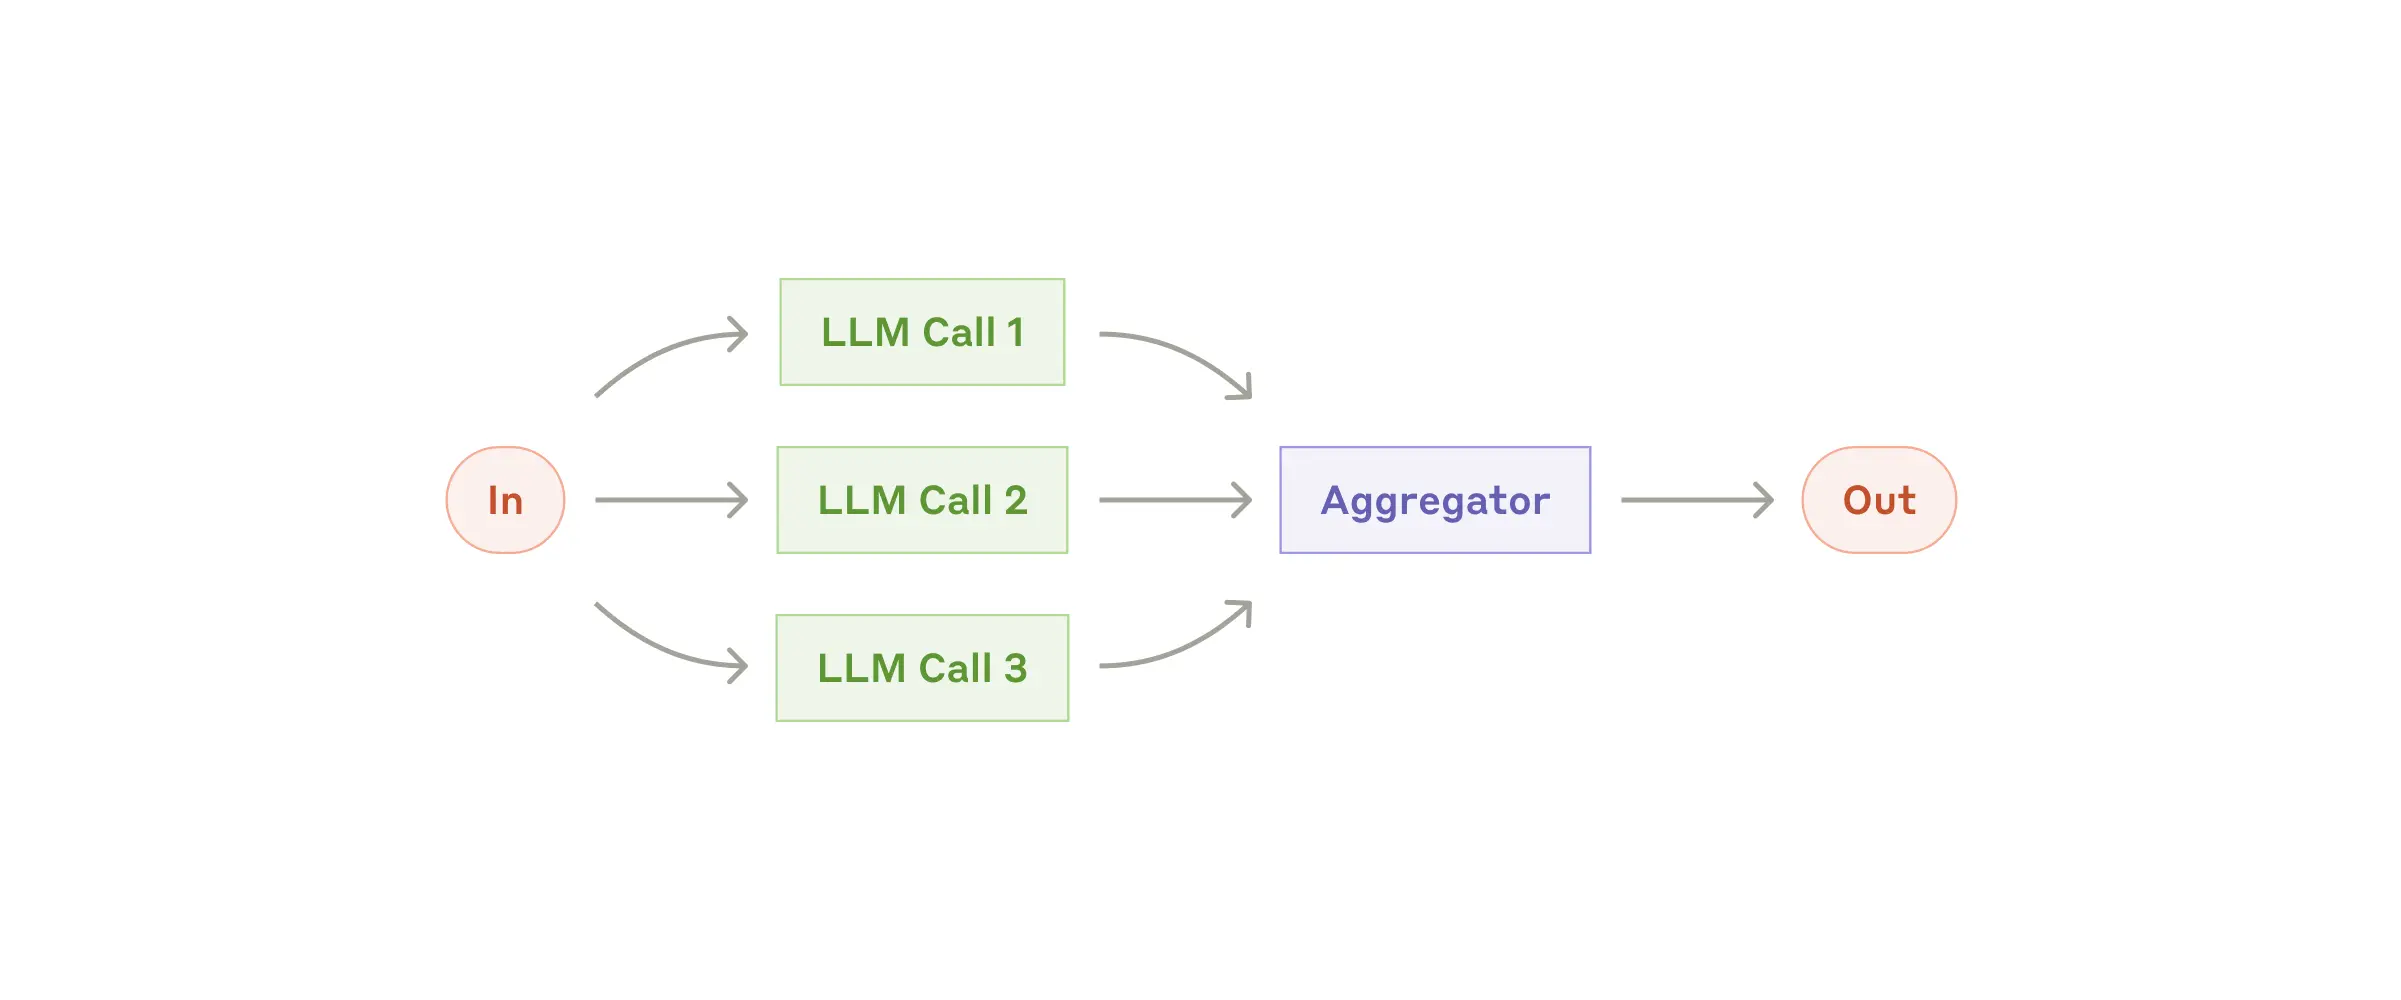

#### Resources

**Documentation**

See our documentation on parallelization here:

https://langchain-ai.github.io/langgraph/how-tos/branching/

**LangChain Academy**
 
See our lesson on parallelization here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb

#### Example Implementation

In [8]:
@task
def call_llm_1(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def call_llm_2(topic: str):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content


@task
def call_llm_3(topic):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content


@task
def aggregator(topic, joke, story, poem):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(
        topic, joke_fut.result(), story_fut.result(), poem_fut.result()
    ).result()

In [9]:
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'call_llm_1': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'call_llm_3': "In a sunbeam's gentle grace they lie,  \nWhiskers twitch as dreams drift by.  \nSoft paws tread on twilight's seam,  \nGuardians of the night's serene.\n\nEmerald eyes, a knowing gleam,  \nIn shadows dance, a silent theme.  \nMysteries held in their midnight fur,  \nSilent whispers, no footfall's stir.\n\nCurled upon a windowsill,  \nWatching worlds in silence still.  \nA regal nod, a subtle purr,  \nThe universe contained in fur.\n\nIn moonlit gardens, they softly prowl,  \nBeneath the stars, they yawn and howl.  \nYet by the fire, they rest and play,  \nTurning night into day.\n\nOh, feline friends, with softest tread,  \nRulers of kingdoms in our head.  \nIn your gaze, a world unfurls—  \nTimeless tales of cats and curls."}


{'call_llm_2': 'Once upon a time in the quaint village of Whiskerfield, nestled between rolling hills and lush meadows, there was a pe

## Routing 

Routing classifies an input and directs it to a specialized followup task. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

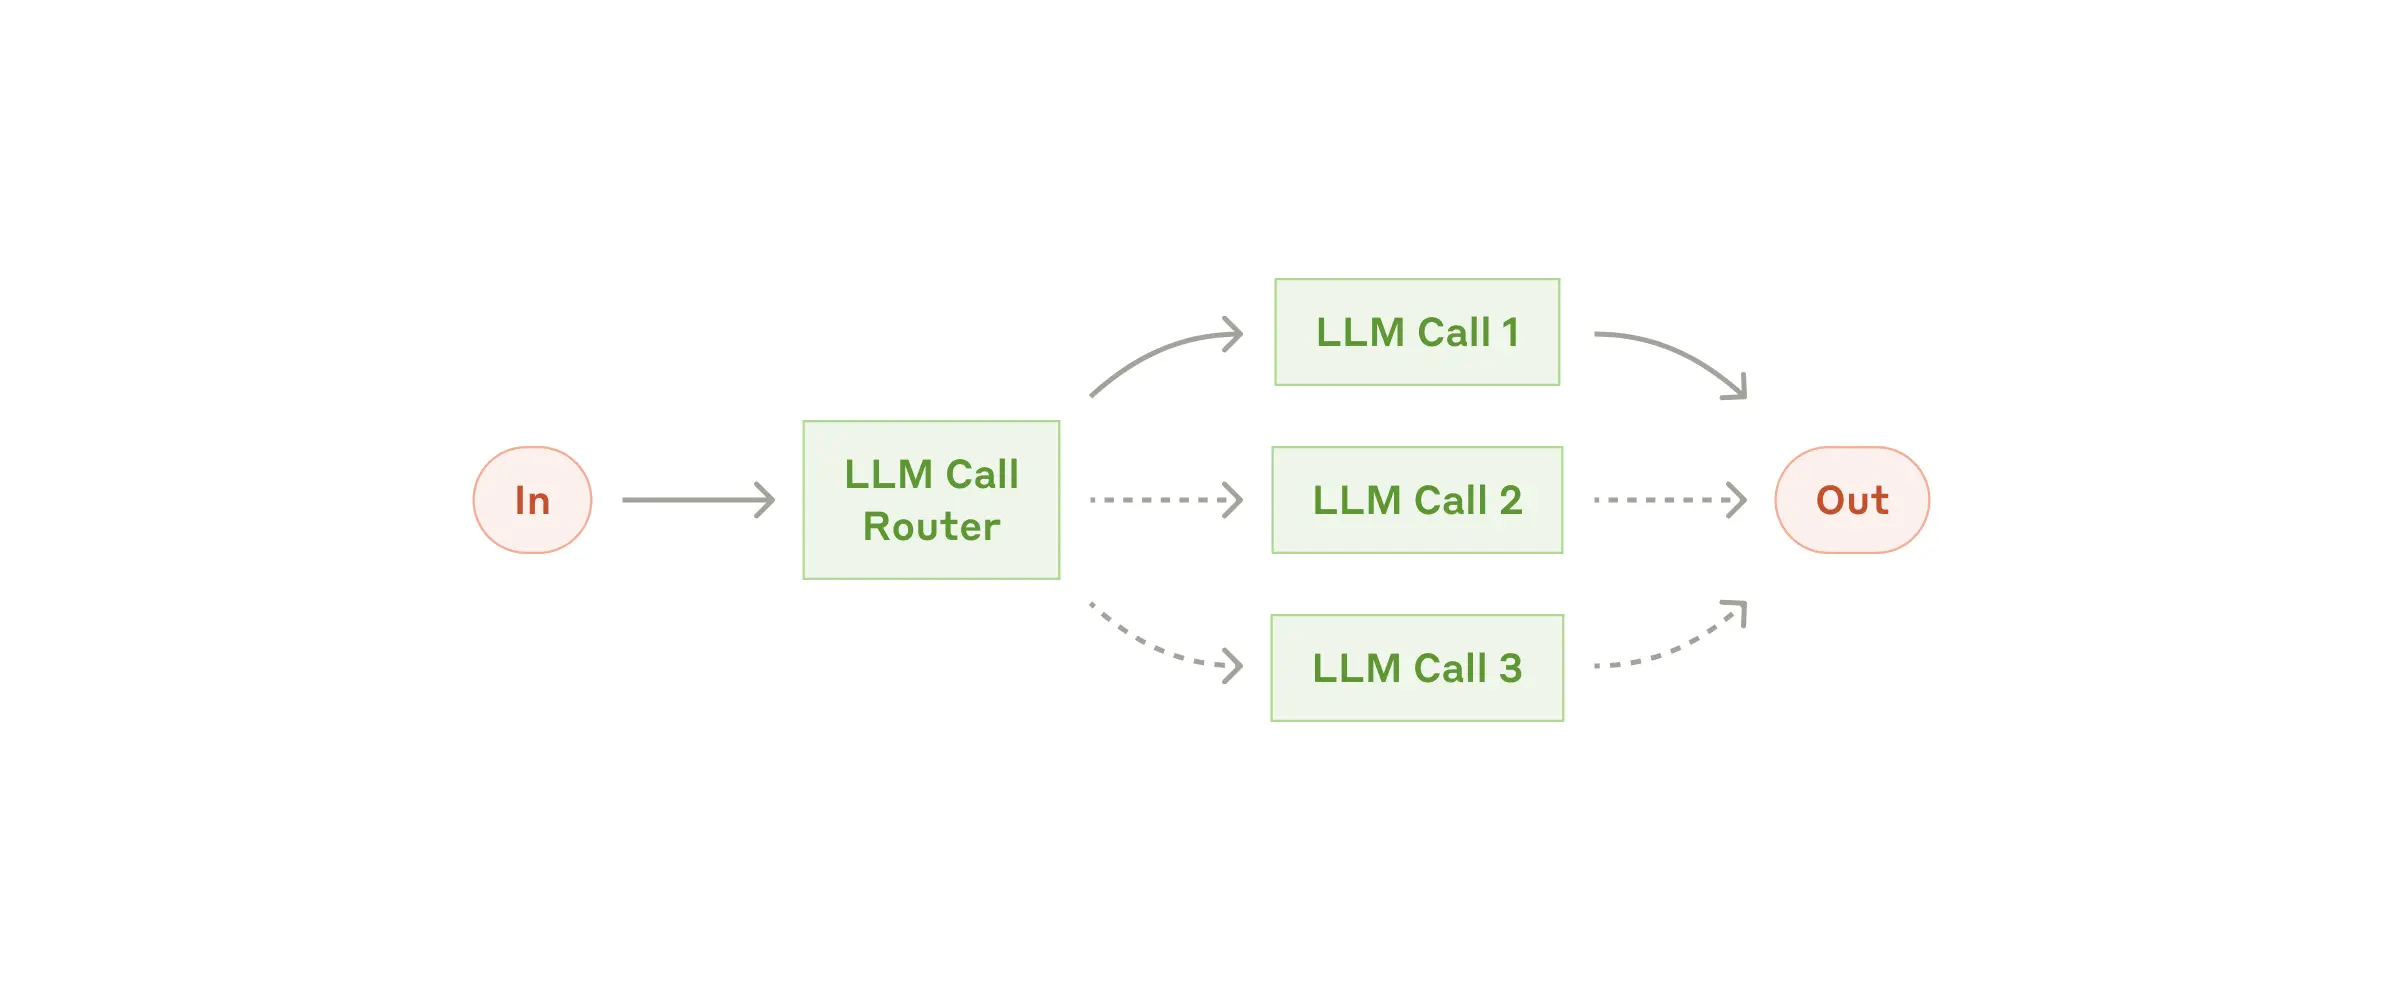

#### Resources

**LangChain Academy**

See our lesson on routing here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb

**Examples**

Here is a project on RAG that utilizes routing to route questions to a vectorstore or web search: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

In [10]:
from typing_extensions import Literal
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


@task
def llm_call_1(input_: str):
    """Write a story"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_2(input_: str):
    """Write a joke"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_3(input_: str):
    """Write a poem"""
    result = llm.invoke(input_)
    return result.content


def llm_call_router(input_: str):
    """Route the input to the appropriate node"""
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=input_),
        ]
    )
    return decision.step


# Compile workflow
@entrypoint()
def router_workflow(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "story":
        llm_call = llm_call_1
    elif next_step == "joke":
        llm_call = llm_call_2
    elif next_step == "poem":
        llm_call = llm_call_3

    return llm_call(input_).result()

In [11]:
for step in router_workflow.stream("Write me a joke about cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_2': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'router_workflow': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}




## Orchestrator-Worker 

A central LLM dynamically breaks down task, delegates them to worker LLMs, and synthesizes their results. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

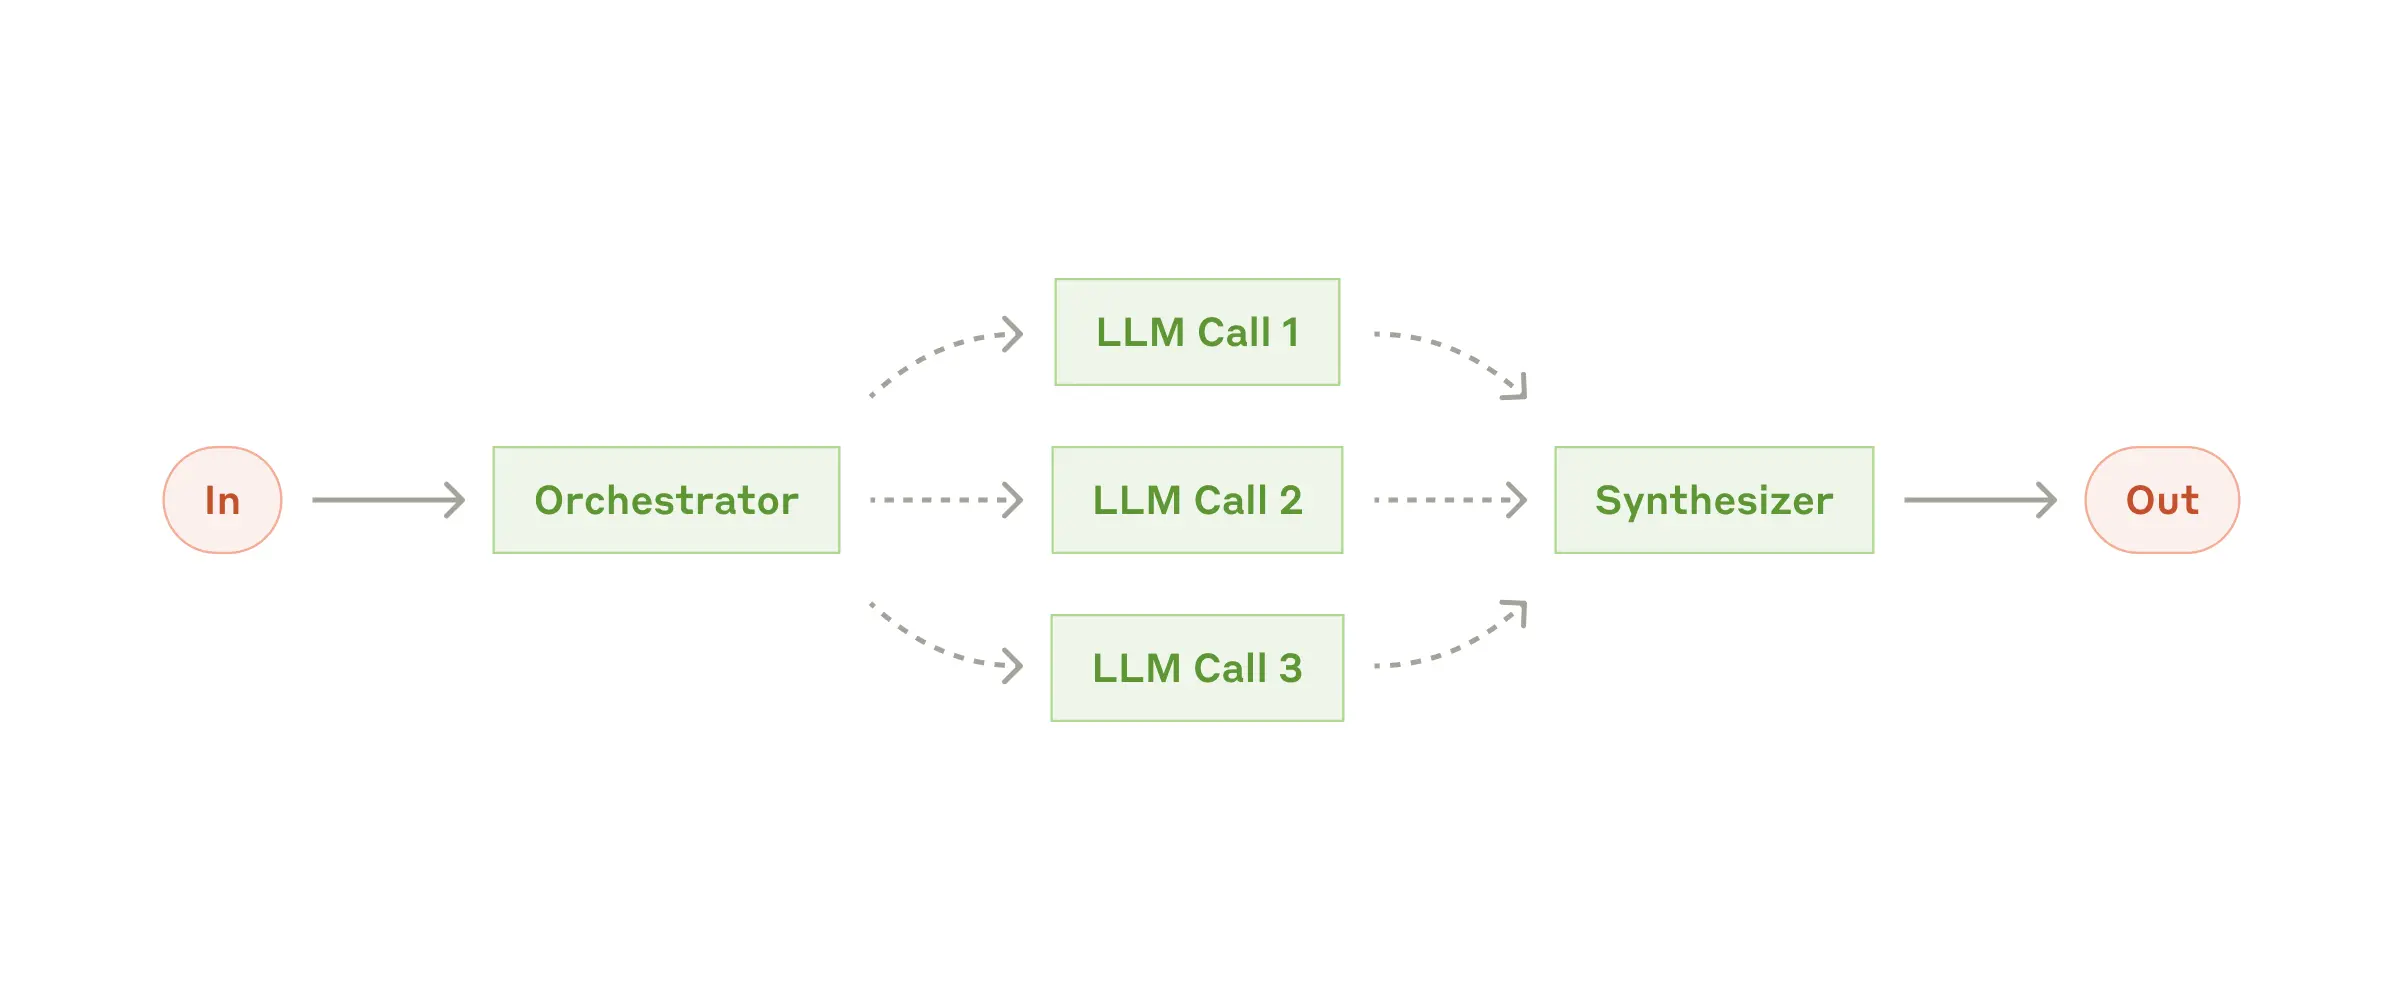

#### Resources

**LangChain Academy**

See our lesson on orchestrator-worker here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb

--- 

**Examples**

Here is a project that uses orchestrator-worker for report planning and writing:

https://github.com/langchain-ai/report-mAIstro

See our video here:

https://www.youtube.com/watch?v=wSxZ7yFbbas
    
#### Example Implementation


In [12]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


@task
def orchestrator(topic: str):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {topic}"),
        ]
    )

    return report_sections.sections


@task
def llm_call(section: Section):
    """Worker writes a section of the report"""

    # Generate section
    result = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return result.content


@task
def synthesizer(completed_sections: list[str]):
    """Synthesize full report from sections"""
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


@entrypoint()
def orchestrator_worker(topic: str):
    sections = orchestrator(topic).result()
    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer(
        [section_fut.result() for section_fut in section_futures]
    ).result()
    return final_report

In [13]:
for step in orchestrator_worker.stream(
    "Create a report on LLM scaling laws", stream_mode="updates"
):
    for key, value in step.items():
        print(f"Executing task '{key}'")

        if key == "orchestrator_worker":
            report = value

Executing task 'orchestrator'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'synthesizer'
Executing task 'orchestrator_worker'


In [14]:
from IPython.display import display, Markdown

In [15]:
Markdown(report)

### Introduction to LLM Scaling Laws

Large Language Models (LLMs) have become a cornerstone in the field of artificial intelligence, showcasing remarkable capabilities in tasks ranging from natural language understanding to creative content generation. As these models continue to evolve, understanding the principles that govern their scaling—both in terms of size and performance—becomes crucial. This is where LLM scaling laws come into play, providing a framework for understanding how increasing the size of models in terms of parameters and data impacts their overall ability.

**Definition and Overview**

LLM scaling laws refer to the empirical relationships that describe how the performance of a language model improves as a function of its size and the amount of data it is trained on. These laws are derived from rigorous experimentation and analysis, revealing predictable patterns that guide the development of more powerful models. Typically, scaling laws highlight the relationship between model size (usually measured in the number of parameters), dataset size, and computational resources, and their collective impact on model accuracy and efficiency.

**Significance in Machine Learning**

The significance of LLM scaling laws lies in their ability to provide a blueprint for designing more effective language models. By understanding these laws, researchers and practitioners can make informed decisions about resource allocation, choosing the right balance between model size and training data to achieve desired performance levels. This is particularly important in the current landscape, where computational resources are finite and the cost of training large models can be substantial.

Scaling laws also facilitate the prediction of a model's performance before full-scale training, enabling more strategic planning and reducing the trial-and-error approach traditionally associated with model development. By leveraging these insights, developers can optimize the architecture and training regimes, potentially accelerating the innovation cycle within the AI community.

**Importance for Development and Deployment**

In the context of development, LLM scaling laws inform the architectural choices, such as layer depth and width, that are likely to yield the best results for a given task. They also highlight the diminishing returns of simply increasing model size without proportionally increasing the data available for training, thereby promoting a more balanced approach to model scaling.

During deployment, understanding scaling laws is critical for estimating the computational resources required to run large models efficiently. It also helps in anticipating the trade-offs between latency, throughput, and accuracy, which are essential considerations in real-world applications where responsiveness and resource consumption are as important as performance.

In conclusion, LLM scaling laws serve as a guiding compass in the burgeoning world of large language models, illuminating the path toward more refined and capable AI systems. As the field advances, continued exploration and refinement of these laws will be essential, ensuring that the development and deployment of LLMs remain both sustainable and impactful.

---

### Historical Background and Development

The concept of scaling laws in machine learning has evolved significantly over the past few decades, tracing its roots back to foundational theories in artificial intelligence and statistical modeling. Initially, the focus was predominantly on developing algorithms that could perform specific tasks efficiently on limited datasets. However, as computational power increased and data became more abundant, researchers began to explore how these algorithms could be scaled to tackle more complex problems.

One of the earliest instances of recognizing the importance of scaling in machine learning was during the 1980s and 1990s, with the development of neural networks. The backpropagation algorithm, introduced in the 1980s, marked a significant breakthrough, allowing for the training of multi-layer networks, albeit on relatively small scales due to computational constraints. During this period, the limitations of scaling were apparent, as larger networks were prone to overfitting and were computationally expensive to train.

The 2000s saw a resurgence of interest in neural networks, spurred by advancements in both hardware, particularly GPUs, and data availability. This era marked the beginning of what is now known as deep learning. Key breakthroughs such as the introduction of convolutional neural networks (CNNs) by Yann LeCun and the development of unsupervised pre-training techniques by Geoffrey Hinton and others demonstrated that scaling up network size and complexity could lead to significant improvements in performance, particularly in areas like image and speech recognition.

The notion of scaling laws themselves began to take a more formal shape in the 2010s, driven by empirical observations that larger models, when trained on larger datasets, tended to perform better. This period also saw the introduction of transformer models, with the publication of the "Attention is All You Need" paper by Vaswani et al. in 2017. Transformers demonstrated unparalleled scalability, leading to the development of increasingly large language models, such as OpenAI's GPT series and Google's BERT and T5 models.

In 2020, OpenAI published a seminal paper on scaling laws for neural language models, which quantitatively described how model performance improved with increased parameter size, data size, and computational resources. This study provided a mathematical framework for understanding the trade-offs and efficiencies associated with scaling, highlighting the diminishing returns at extreme scales but also underscoring the potential for large models to generalize better across diverse tasks.

The development of scaling laws has not only enhanced our understanding of model performance but has also influenced practical considerations in model deployment and resource allocation. The realization that larger models require careful management of computational resources and energy efficiency has led to innovations in model compression, such as distillation and pruning, and the development of scalable infrastructure, like distributed training and cloud-based solutions.

In summary, the historical development of scaling laws in machine learning reflects a broader trajectory of increasing model complexity and capacity, driven by both theoretical insights and technological advancements. As we continue to push the boundaries of what is possible with machine learning, scaling laws will undoubtedly remain a critical area of research, guiding the development of next-generation models and applications.

---

## Key Principles of LLM Scaling Laws

In the realm of large language models (LLMs), scaling laws provide a framework for understanding how changes in model size, data quantity, and computational resources impact performance. These scaling laws are crucial for guiding the development and optimization of LLMs, ensuring that they maintain efficiency and effectiveness as they grow. This section delves into the core principles of LLM scaling laws, focusing on parameter scaling, data scaling, and compute scaling.

### Parameter Scaling

Parameter scaling refers to the practice of increasing the number of parameters in a language model to enhance its ability to learn and generalize from data. Parameters in an LLM typically include weights and biases that the model adjusts during training to minimize error. The principle of parameter scaling is grounded in the observation that larger models, with more parameters, tend to perform better on a wide range of tasks. This is because larger models can capture more complex patterns and nuances in data. However, there is a point of diminishing returns, where adding more parameters yields smaller improvements in performance relative to the additional computational cost and potential overfitting challenges. Therefore, identifying the optimal size for a model is a critical aspect of parameter scaling.

### Data Scaling

Data scaling involves increasing the amount of training data to improve the model's performance. The underlying principle is that more data provides a richer and more diverse set of examples from which the model can learn. This diversity helps the model to generalize better to unseen data, reducing the risk of overfitting to the peculiarities of a smaller dataset. As with parameter scaling, there are limits to the benefits of data scaling, particularly if the additional data is not of high quality or diversity. Ensuring that the data is representative of the tasks for which the LLM is intended is essential for maximizing the benefits of data scaling.

### Compute Scaling

Compute scaling is the enhancement of computational resources allocated to training and running LLMs. This includes advancements in hardware, such as GPUs and TPUs, as well as optimizations in software frameworks that allow for more efficient model training and inference. The principle behind compute scaling is that more computational power allows for the training of larger models on larger datasets, thereby potentially improving performance. Compute scaling also involves parallelization and distribution strategies to manage the substantial computational loads associated with large models. A key challenge in compute scaling is balancing the cost of increased computational resources against the gains in model performance.

### Interplay Between Scaling Principles

The principles of parameter scaling, data scaling, and compute scaling are not isolated; they interact in complex ways that influence the overall performance and efficiency of LLMs. For instance, increasing the number of parameters without sufficient data can lead to overfitting, while ample data without adequate compute resources may result in impractically long training times. Thus, effective scaling strategies require a holistic approach that considers the synergies and trade-offs between these elements.

In conclusion, understanding and applying the principles of LLM scaling laws is essential for optimizing the performance of large language models. By strategically managing parameters, data, and compute resources, developers can create models that are both powerful and efficient, capable of meeting the demands of diverse and complex language processing tasks.

---

## Applications and Implications

The scaling laws of large language models (LLMs) have emerged as a critical area of research, providing valuable insights into the performance and capabilities of these models as they grow in size and complexity. Understanding these laws has profound implications for the practical application of LLMs across various domains and significantly influences the trajectory of AI research and technology development.

### Practical Applications

1. **Natural Language Processing (NLP)**
   The scaling laws have facilitated the development of more sophisticated NLP applications. As LLMs grow, they exhibit improved understanding and generation of human language, enabling more accurate and contextually aware machine translation, sentiment analysis, and text summarization. These advancements enhance user experiences across platforms like social media, customer service, and content creation.

2. **Healthcare**
   In healthcare, LLMs have been applied in medical diagnostics and personalized treatment plans. By training on vast datasets, these models can assist in interpreting medical literature, predicting patient outcomes, and even suggesting potential therapies, thereby augmenting the decision-making capabilities of healthcare professionals.

3. **Education**
   LLMs are being integrated into educational tools, offering personalized learning experiences. They can adapt to individual learning paces, provide instant feedback, and facilitate language learning through interactive conversations, thereby making education more accessible and tailored to diverse learner needs.

4. **Creative Industries**
   The creative industries have seen a surge in the use of LLMs for generating content, such as writing, music, and art. These models can assist artists by providing inspiration, automating routine tasks, and even generating novel ideas, thereby expanding the boundaries of human creativity.

### Implications for AI Research and Technology

1. **Model Efficiency and Resource Utilization**
   The scaling laws indicate that larger models tend to perform better, but they also require more computational resources. This has driven research into optimizing model efficiency and developing techniques like model pruning, quantization, and distillation, which aim to reduce the resource footprint while maintaining performance.

2. **Ethical and Social Considerations**
   As LLMs become more pervasive, ethical considerations regarding their use have gained prominence. The scaling laws highlight the potential for biases present in training data to be amplified, necessitating ongoing efforts to ensure fairness, accountability, and transparency in AI systems.

3. **Economic Impact**
   The widespread application of LLMs is reshaping industries and job markets. While they create opportunities for innovation and efficiency, there is also the potential for disruption in traditional job roles, prompting a need for workforce adaptation and reskilling initiatives.

4. **Future Research Directions**
   The insights from LLM scaling laws are guiding future research directions, including exploring the limits of model size, developing more generalizable AI systems, and understanding the emergent properties of these models. This research is crucial for advancing AI toward more human-like understanding and interaction.

In conclusion, the scaling laws of LLMs provide a foundational framework that is driving both the application and evolution of AI technologies. As these models continue to grow and integrate into various facets of society, it is imperative to address the associated challenges and harness their potential to benefit humanity responsibly and sustainably.

---

### Challenges and Limitations

The scaling laws associated with Large Language Models (LLMs) have been instrumental in driving the progress of artificial intelligence, particularly in natural language processing tasks. However, the pursuit of larger and more powerful models is not without its challenges and limitations. This section delves into the critical issues that arise in the context of LLM scaling, focusing on computational resources, efficiency, and ethical considerations.

#### Computational Resources

One of the most significant challenges in scaling LLMs is the immense computational resources required to train these models. As model size increases, the demand for high-performance computing infrastructure, including Graphics Processing Units (GPUs) and Tensor Processing Units (TPUs), also escalates. This not only raises the financial cost of training large models but also imposes a barrier to entry for smaller organizations and research institutions that may lack the necessary resources.

Moreover, the energy consumption associated with training large-scale models is substantial, contributing to environmental concerns. The carbon footprint of training these models can be considerable, prompting a need for more sustainable approaches to model development and deployment.

#### Efficiency

Efficiency is another critical limitation when it comes to LLM scaling. Despite their impressive capabilities, larger models often suffer from diminishing returns in terms of performance improvements relative to their size. This can lead to inefficient use of computational resources, where the incremental gains in accuracy or capability do not justify the exponential increase in model size and training time.

Efforts to enhance model efficiency have led to the exploration of various techniques, such as model pruning, quantization, and knowledge distillation. However, these methods can introduce trade-offs between model size, speed, and performance, complicating the optimization process.

#### Ethical Considerations

The ethical implications of scaling LLMs cannot be overlooked. As models become more complex and powerful, they also pose greater risks in terms of misuse and unintended consequences. Larger models can inadvertently learn and amplify biases present in training data, leading to biased outputs that can perpetuate stereotypes or discrimination.

Additionally, the opacity of LLMs makes it challenging to understand their decision-making processes, raising concerns about accountability and transparency. As these models are increasingly deployed in critical applications, the lack of interpretability can hinder trust and complicate the detection and mitigation of harmful outputs.

Furthermore, the concentration of power and knowledge in a few large organizations with the capability to develop and maintain LLMs exacerbates concerns about monopolization and the equitable distribution of technological benefits. This concentration can stifle innovation and limit access to cutting-edge AI technologies for diverse stakeholders.

#### Conclusion

In summary, while LLM scaling laws offer a pathway to more advanced AI capabilities, they also present a complex array of challenges and limitations that must be addressed. Balancing the pursuit of larger models with the need for efficiency, ethical responsibility, and equitable access is crucial to ensuring that the benefits of AI advancements are realized in a sustainable and inclusive manner. Future research and policy-making should focus on developing innovative solutions that mitigate these challenges while continuing to push the boundaries of what is possible with LLMs.

---

## Future Directions and Research

The field of Large Language Models (LLMs) is rapidly evolving, driven by the increasing demand for more efficient, accurate, and flexible AI systems. As the understanding of LLM scaling laws progresses, several potential future directions for research can be identified. These directions not only aim to enhance the capabilities of LLMs but also address existing challenges and explore new frontiers in artificial intelligence.

### Emerging Trends

1. **Efficient Scaling**: One of the most significant emerging trends is the pursuit of more efficient scaling techniques. Researchers are increasingly focusing on optimizing the computational resources required to train and deploy LLMs. This includes exploring sparsity techniques, low-rank approximations, and model distillation methods to reduce the size and energy consumption of these models without compromising performance.

2. **Multimodal Models**: There is a growing interest in developing models that can process and understand multiple types of data, such as text, images, and audio. This trend is driving research into scaling laws that account for the complexities of integrating diverse data modalities, potentially leading to more versatile and capable AI systems.

3. **Interpretability and Transparency**: As LLMs become more integral to decision-making processes, understanding their internal mechanisms becomes crucial. Future research will likely focus on developing scaling laws that not only enhance model performance but also improve interpretability, allowing users to gain insights into how and why models make certain predictions.

### New Methodologies

1. **Meta-Learning and AutoML**: Incorporating meta-learning and automated machine learning (AutoML) techniques into the scaling process is a promising area of exploration. These methodologies could enable models to learn more effectively from smaller datasets and adapt quickly to new tasks, enhancing their scalability and applicability across various domains.

2. **Federated Learning and Edge AI**: With the rise of privacy concerns and the need for decentralized computing, federated learning and edge AI are becoming increasingly relevant. Future research could explore scaling laws that support these paradigms, enabling LLMs to operate efficiently across distributed networks while maintaining data privacy.

3. **Robustness and Generalization**: Developing scaling laws that enhance the robustness and generalization capabilities of LLMs is another critical area. This includes creating models that are less susceptible to adversarial attacks, can handle out-of-distribution data more effectively, and maintain performance across diverse environments.

### Areas Requiring Further Exploration

1. **Ethical and Social Implications**: As LLMs continue to scale, their ethical and social implications become more pronounced. Research in this area should focus on understanding and mitigating biases, ensuring fairness, and preventing the misuse of LLMs in sensitive applications.

2. **Non-English Languages and Low-Resource Settings**: Many LLMs are predominantly trained on English datasets, which limits their applicability in non-English and low-resource settings. Future research should aim to develop scaling laws that facilitate the creation of models capable of understanding and generating text in a wider array of languages and dialects.

3. **Hybrid Models and Human-AI Collaboration**: Exploring the integration of LLMs with other AI paradigms, such as symbolic reasoning and cognitive computing, could lead to hybrid models that combine the strengths of different approaches. Additionally, enhancing human-AI collaboration through intuitive interfaces and explainable AI could open new avenues for research and application.

In conclusion, the future directions and research in LLM scaling laws are poised to address significant challenges and unlock new possibilities in artificial intelligence. By focusing on efficiency, interpretability, robustness, and ethical considerations, researchers can ensure that LLMs continue to evolve in ways that are both technologically advanced and socially responsible.

---

**Conclusion and Description:**

In this report, we have explored the burgeoning field of large language models (LLMs) and the scaling laws that govern their development and implementation. The main points discussed include the foundational principles of LLM scaling laws, their empirical and theoretical underpinnings, and their profound impact on the advancement of artificial intelligence.

Scaling laws, which describe how the performance of language models improves with increased data, model size, and computational power, have emerged as pivotal guidelines for AI researchers and practitioners. These laws have facilitated a deeper understanding of model efficiency and effectiveness, enabling the development of more sophisticated and powerful AI systems. By adhering to these scaling laws, researchers have been able to predict the outcomes of model scaling, optimize resource allocation, and effectively plan for future expansions in model capabilities.

One of the primary discussions in this report centered around the empirical evidence supporting LLM scaling laws. We highlighted various studies that demonstrate consistent performance gains as models are scaled, both in terms of size and the volume of data processed. This empirical validation underscores the reliability of scaling laws as a framework for guiding model development and has led to significant advancements in natural language processing tasks, such as language translation, sentiment analysis, and text generation.

Furthermore, the report delved into the theoretical aspects of LLM scaling laws. We examined the mathematical models and hypotheses proposed by leading researchers, which aim to explain why and how these scaling laws hold. Understanding these theoretical foundations is crucial for driving innovation and addressing the limitations of current models, such as diminishing returns at extreme scales and the environmental impact of large-scale computations.

The impact of LLM scaling laws on the field of AI cannot be overstated. They have revolutionized the way researchers approach model design, pushing the boundaries of what is possible with AI technology. The advancements facilitated by adherence to scaling laws have not only enhanced the capabilities of AI systems but have also opened new avenues for research and application across various industries.

In conclusion, the exploration of LLM scaling laws represents a significant stride in the evolution of artificial intelligence. By summarizing the main points discussed, we reiterate the importance of these laws in shaping the future of AI. As researchers continue to refine and expand upon these principles, the potential for groundbreaking innovations in AI technology remains vast, promising transformative impacts on society and industry alike.

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

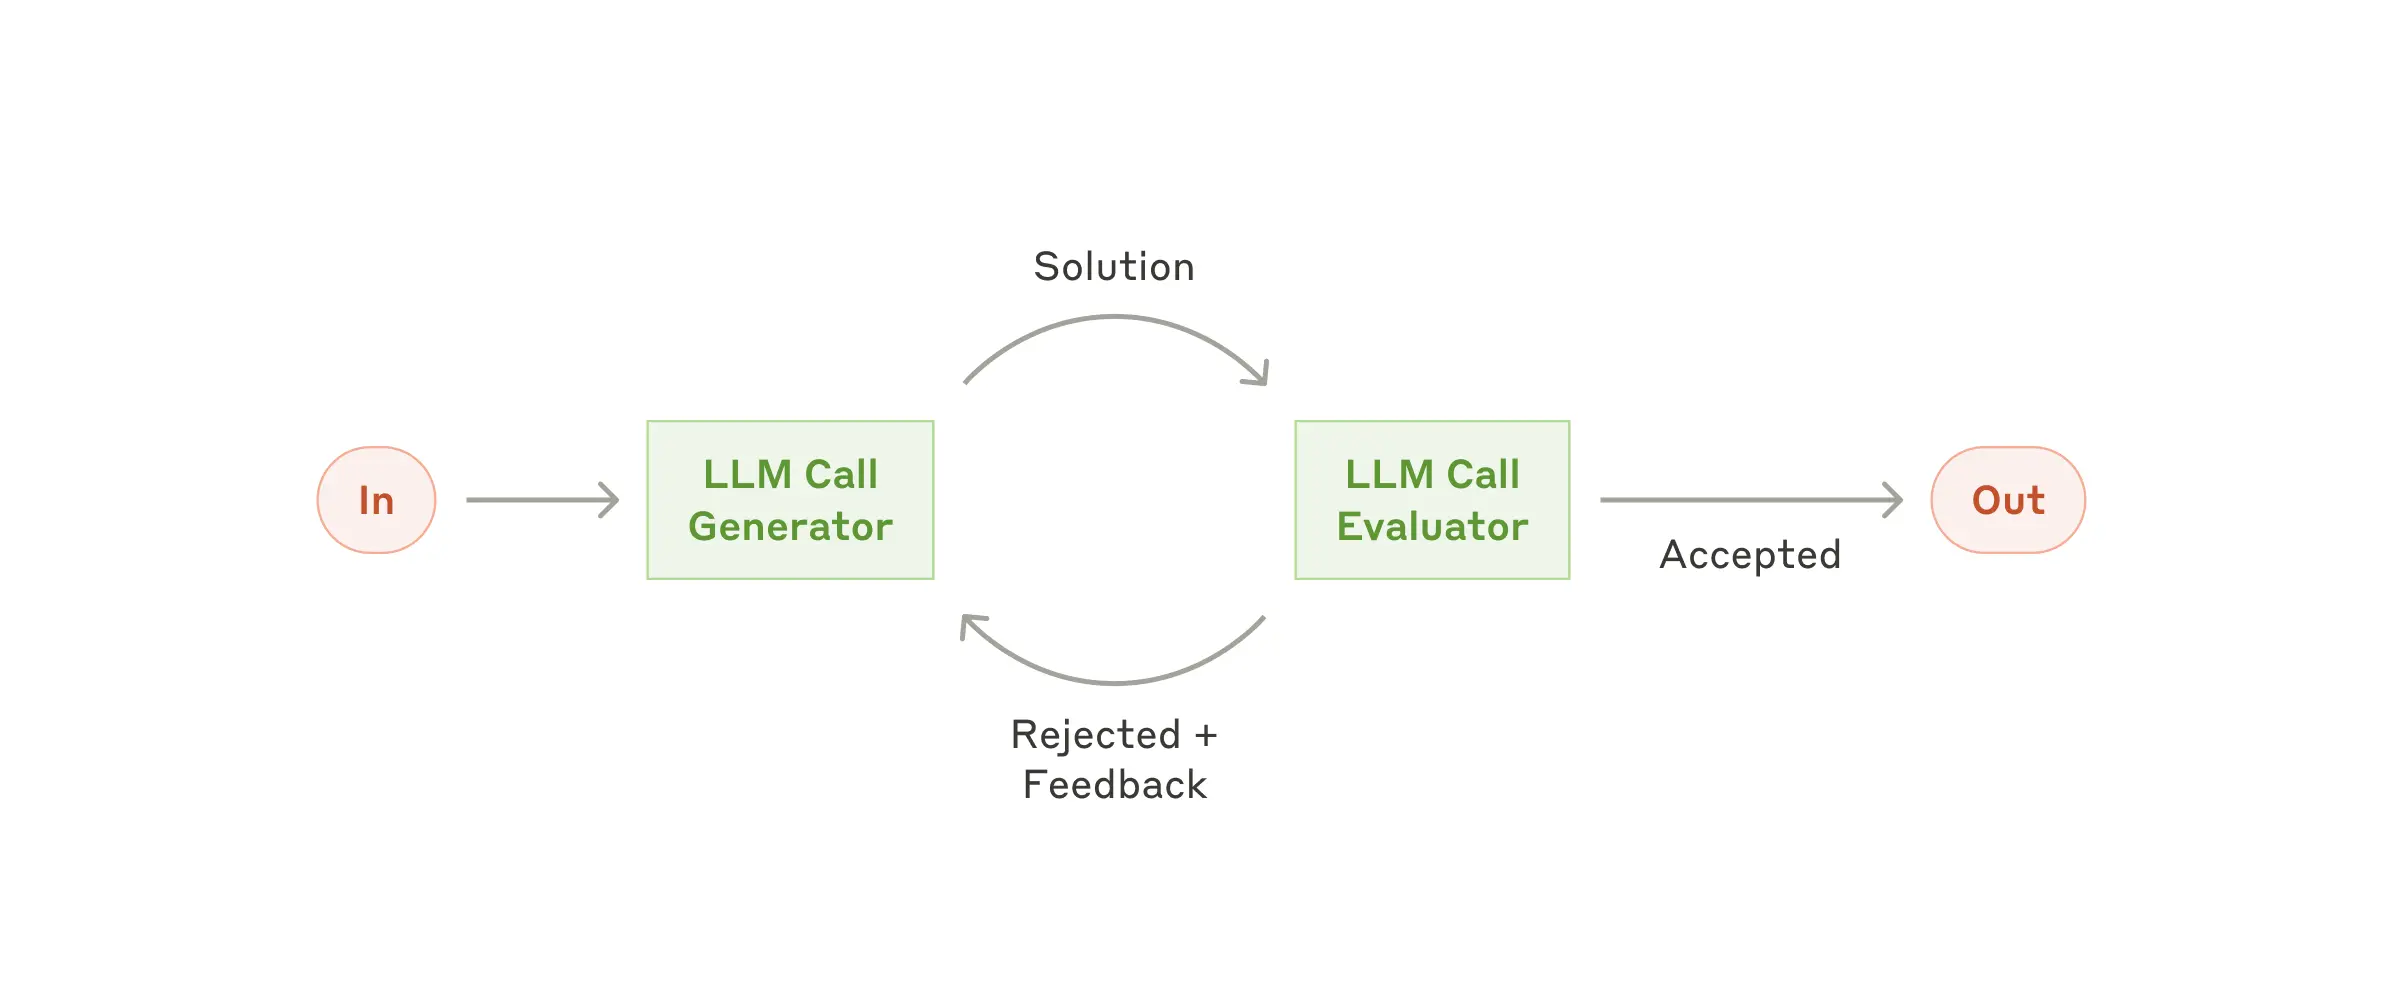

#### Resources

**Examples**

Here is a project that uses evaluator-optimizer to iteratively improve a report:

https://github.com/langchain-ai/research-rabbit

See our video on here:

https://www.youtube.com/watch?v=XGuTzHoqlj8

--- 

Here is a project on RAG that utilizes grading to check answers for hallucinations or factual errors: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

In [16]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
@task
def llm_call_generator(topic: str, feedback: Feedback):
    """LLM generates a joke"""
    if feedback:
        msg = llm.invoke(
            f"Write a joke about {topic} but take into account the feedback: {feedback}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def llm_call_evaluator(joke: str):
    """LLM evaluates the joke"""
    feedback = evaluator.invoke(f"Grade the joke {joke}")
    return feedback


@entrypoint()
def optimizer_workflow(topic: str):
    feedback = None
    while True:
        joke = llm_call_generator(topic, feedback).result()
        feedback = llm_call_evaluator(joke).result()
        if feedback.grade == "funny":
            break

    return joke

In [17]:
for step in optimizer_workflow.stream("Cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_generator': 'Why was the cat sitting on the computer?  \nBecause it wanted to keep an eye on the mouse!'}


{'llm_call_evaluator': Feedback(grade='funny', feedback="The joke is funny because it plays on the double meaning of 'mouse,' referring both to the computer accessory and the animal that cats are known to chase. It's a clever use of wordplay.")}


{'optimizer_workflow': 'Why was the cat sitting on the computer?  \nBecause it wanted to keep an eye on the mouse!'}




## Agent 

Agents are typically just LLMs using tools based on environmental feedback in a loop. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

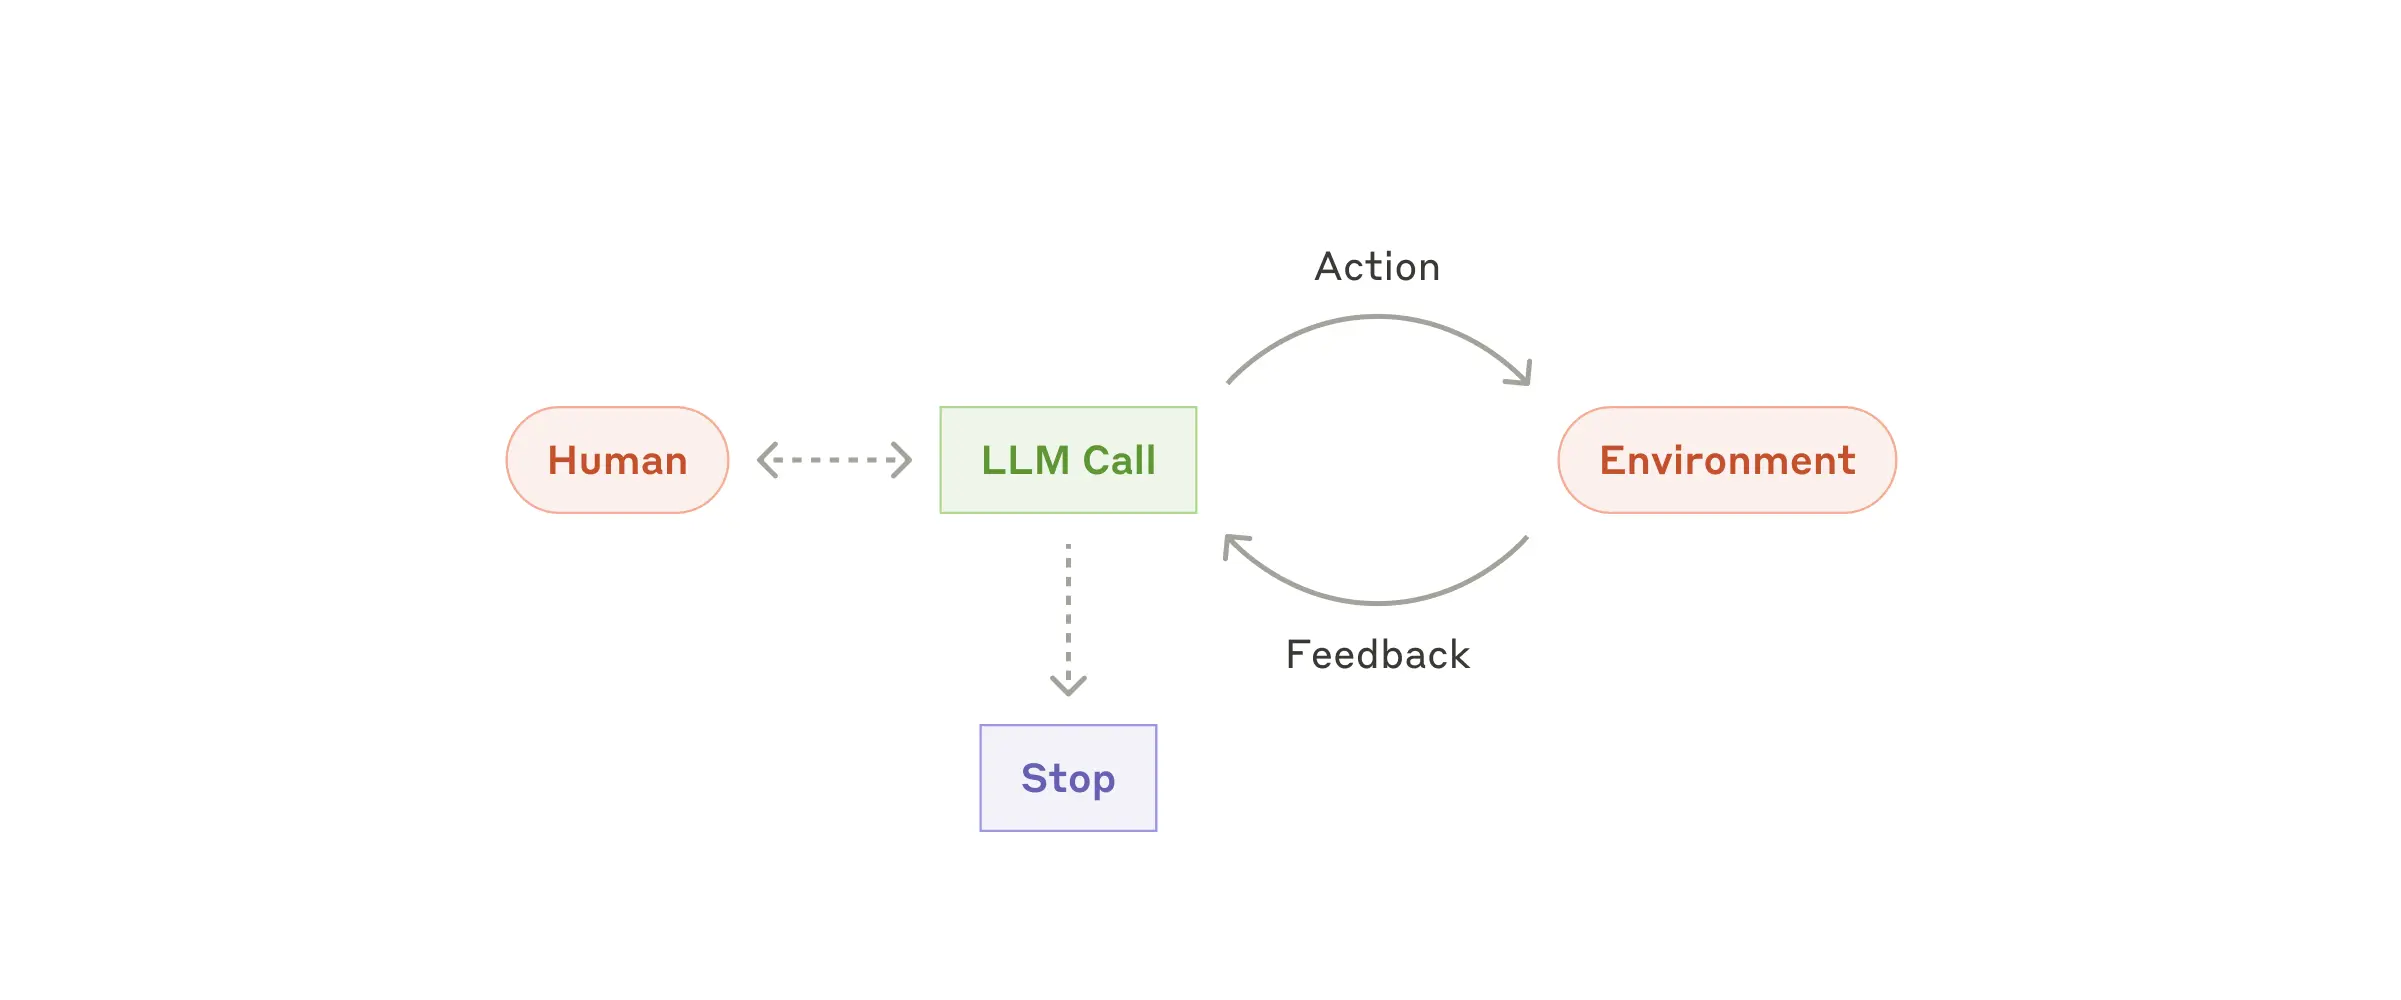

#### Resources

**LangChain Academy**

See our lesson on agents here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb

--- 

**Examples**

Here is a project that uses a tool calling agent to create / store long-term memories:

https://github.com/langchain-ai/memory-agent

#### Example Implementation


In [18]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [19]:
from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    ToolMessage,
    BaseMessage,
    ToolCall,
)


@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    observation = tool.invoke(tool_call["args"])
    return ToolMessage(content=observation, tool_call_id=tool_call["id"])


# Compile the agent
@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

In [20]:
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VkBoN2yGwj3CLUTxO8K9pTJV', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eb095581-6f92-48e4-bd07-a2e6f6a3851d-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_VkBoN2yGwj3CLUTxO8K9pTJV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 18, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'c

---

## What LangGraph provides

By constructing each of the above in LangGraph, we get a few things that are important for building effective agents and workflows.

### Streaming 

LangGraph provides several ways to stream state of the agent or workflow. 

See Module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb

### Human-in-the-Loop

LangGraph persistence layer supports interruption and approval of the agent's actions (e.g., Human In The Loop). 

See Module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-3

### Memory 

LangGraph persistence layer supports conversational (short-term) memory as well as long-term memory. 

See Modules 2 and 5 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-2

https://github.com/langchain-ai/langchain-academy/tree/main/module-5

### Deployment and Observability

LangGraph provides an easy on-ramp for deployment, observability, and evaluation. 

See module 6 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-6